In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras import regularizers
from keras import layers
from ipywidgets import widgets
from io import BytesIO

In [ ]:
!git clone https://github.com/GitKentC/dataset.git

Cloning into 'dataset'...
remote: Enumerating objects: 15514, done.
remote: Total 15514 (delta 0), reused 0 (delta 0), pack-reused 15514 (from 1)
Receiving objects: 100% (15514/15514), 236.08 MiB | 27.45 MiB/s, done.
Resolving deltas: 100% (21/21), done.
Updating files: 100% (30916/30916), done.


In [ ]:
DATASET_DIR = '/content/dataset/dupe_cleaned/garbage_classification'
TRAIN_DIR = '/content/dataset/split/garbage_classification/train'
VALIDATION_DIR = '/content/dataset/split/garbage_classification/validation'
TEST_DIR = '/content/dataset/split/garbage_classification/test'

In [ ]:
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 64
LABEL_MODE = 'categorical'
COLOR_MODE = 'rgb'

def load_datasets():
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        TRAIN_DIR,
        image_size = IMAGE_SIZE,
        batch_size = BATCH_SIZE,
        label_mode = LABEL_MODE,
        color_mode = COLOR_MODE,
        pad_to_aspect_ratio = True
    )

    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        VALIDATION_DIR,
        image_size = IMAGE_SIZE,
        batch_size = BATCH_SIZE,
        label_mode = LABEL_MODE,
        color_mode = COLOR_MODE,
        pad_to_aspect_ratio = True
    )

    test_dataset = tf.keras.utils.image_dataset_from_directory(
        TEST_DIR,
        image_size = IMAGE_SIZE,
        batch_size = BATCH_SIZE,
        label_mode = LABEL_MODE,
        color_mode = COLOR_MODE,
        pad_to_aspect_ratio = True
    )

    return train_dataset, validation_dataset, test_dataset

In [ ]:
train_dataset, validation_dataset, test_dataset = load_datasets()

Found 10815 files belonging to 12 classes.
Found 3087 files belonging to 12 classes.
Found 1556 files belonging to 12 classes.


In [ ]:
def preprocess(image, label):
    image = tf.keras.layers.CenterCrop(224, 224)(image)
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

train_dataset = train_dataset.map(preprocess)
validation_dataset = validation_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

In [ ]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset_final = (train_dataset
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       )

validation_dataset_final = (validation_dataset
                            .cache()
                            .prefetch(PREFETCH_BUFFER_SIZE)
                            )

test_dataset_final = (test_dataset
                      .cache()
                      .prefetch(PREFETCH_BUFFER_SIZE)
                      )

In [ ]:
def create_augmentation_model():
    FILL_MODE = 'nearest'

    augmentation_model = tf.keras.Sequential([
        tf.keras.Input(shape=(224, 224, 3)),
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.2, fill_mode = FILL_MODE),
        tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode = FILL_MODE),
        tf.keras.layers.RandomZoom(0.2, fill_mode = FILL_MODE),
    ])

    return augmentation_model

augmentation_model = create_augmentation_model()

In [ ]:
def create_pre_trained_model():
    pre_trained_model = tf.keras.applications.ResNet50(
        include_top = False,
        input_shape = (224, 224, 3),
        weights = "imagenet"
    )

    for layer in pre_trained_model.layers:
        layer.trainable = False

    return pre_trained_model

pre_trained_model = create_pre_trained_model()
pre_trained_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
last_output = pre_trained_model.output

print('Last layer output shape: ', last_output.shape)

Last layer output shape:  (None, 7, 7, 2048)


In [ ]:
def create_model(augmentation_model, pre_trained_model):
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = augmentation_model(inputs)
    x = pre_trained_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0008))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    # x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0008))(x)
    # x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(12, activation='softmax')(x)

    model = tf.keras.Model(inputs = inputs, outputs = outputs)

    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss = 'categorical_crossentropy',
        metrics = ['accuracy']
    )

    return model

model = create_model(augmentation_model, pre_trained_model)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │           6,156 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,642,956 (94.01 MB)

 Trainable params: 1,055,244 (4.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')
        if accuracy >= 0.95 and val_accuracy >= 0.96:
            self.model.stop_training = True
            print(f"\nReached accuracy: {accuracy:.4f} and val_accuracy: {val_accuracy:.4f}, so cancelling training!")

In [ ]:
history = model.fit(train_dataset_final,
                    validation_data = validation_dataset_final,
                    epochs = 50,
                    verbose = 2,
                    callbacks = [EarlyStoppingCallback()]
                    )

Epoch 1/50
169/169 - 108s - 636ms/step - accuracy: 0.6817 - loss: 1.6886 - val_accuracy: 0.9018 - val_loss: 0.9956
Epoch 2/50
169/169 - 54s - 321ms/step - accuracy: 0.8362 - loss: 1.1506 - val_accuracy: 0.9219 - val_loss: 0.8954
Epoch 3/50
169/169 - 83s - 492ms/step - accuracy: 0.8684 - loss: 1.0377 - val_accuracy: 0.9304 - val_loss: 0.8369
Epoch 4/50
169/169 - 54s - 320ms/step - accuracy: 0.8837 - loss: 0.9672 - val_accuracy: 0.9336 - val_loss: 0.8041
Epoch 5/50
169/169 - 83s - 493ms/step - accuracy: 0.8893 - loss: 0.9171 - val_accuracy: 0.9423 - val_loss: 0.7691
Epoch 6/50
169/169 - 54s - 320ms/step - accuracy: 0.9002 - loss: 0.8764 - val_accuracy: 0.9466 - val_loss: 0.7407
Epoch 7/50
169/169 - 83s - 493ms/step - accuracy: 0.9017 - loss: 0.8480 - val_accuracy: 0.9449 - val_loss: 0.7216
Epoch 8/50
169/169 - 82s - 483ms/step - accuracy: 0.9135 - loss: 0.8046 - val_accuracy: 0.9482 - val_loss: 0.6988
Epoch 9/50
169/169 - 63s - 371ms/step - accuracy: 0.9147 - loss: 0.7813 - val_accuracy:

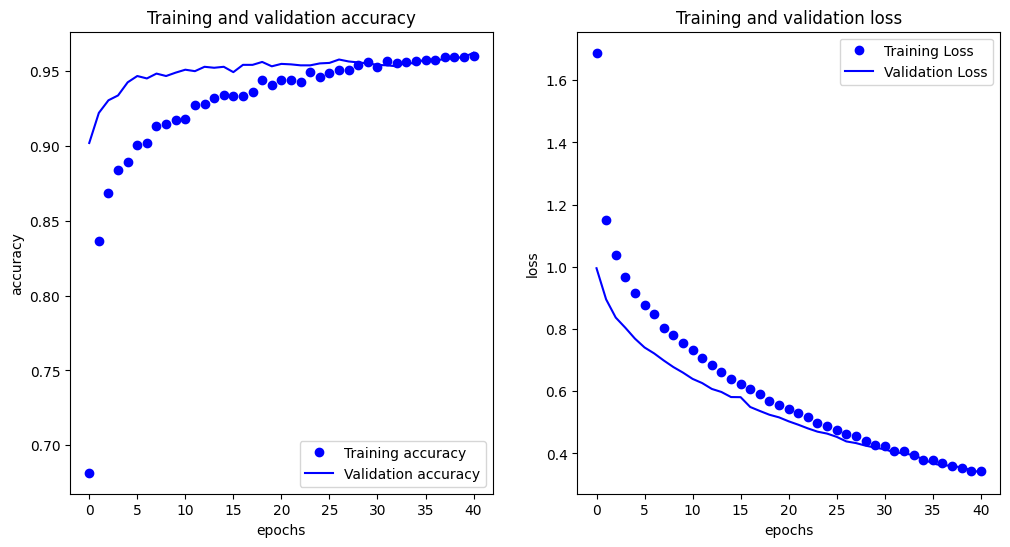

In [ ]:
def plot_loss_acc(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()

    ax[1].plot(epochs, loss, 'bo', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()

    plt.show()

plot_loss_acc(history)

In [ ]:
loss, accuracy = model.evaluate(test_dataset_final, verbose=1)
print("Test Loss:", loss)

25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 250ms/step - accuracy: 0.9561 - loss: 0.3589
Test Loss: 0.3584388792514801
Test Accuracy: 0.9575835466384888
